# GradCAM - Gradient Class Activation Map

In [1]:
# !git clone https://github.com/parth1620/GradCAM-Dataset.git
# !pip install -U git+https://github.com/albumentations-team/albumentations
# !pip install --upgrade opencv-contrib-python

# Imports

In [2]:
import os
os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2

from albumentations.pytorch import ToTensorV2

import torch
from torch import nn
import torch.nn.functional as F

from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms as T

from tqdm import tqdm
import albumentations as A
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import utils
import os # <-- 1. Import the 'os' module

/opt/anaconda3/envs/visualization/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Configurations

In [3]:
if torch.backends.mps.is_available():
    DEVICE = torch.device("mps")
else:
    DEVICE = torch.device("cpu")

print(f"Using device: {DEVICE}")


CSV_FILE= 'train.csv'
DATA_DIR = ''

BATCH_SIZE = 16
LR = 0.001
EPOCHs = 20

Using device: mps


In [4]:
data = pd.read_csv(CSV_FILE)
data.head()

,img_path,label
0,train_images/mushroom_51.jpg,2
1,train_images/eggplant_37.jpg,1
2,train_images/mushroom_20.jpg,2
3,train_images/eggplant_51.jpg,1
4,train_images/eggplant_26.jpg,1


In [5]:
# cucumber - 0, eggplant - 1, mushroom - 2

train_df, valid_df = train_test_split(data, test_size = 0.2, random_state = 42)

# Augmentations

In [6]:
train_augs = A.Compose([
    A.Rotate(),
    A.HorizontalFlip(p = 0.5),
    A.VerticalFlip(p = 0.5),
    A.Normalize(mean = [0.485, 0.456, 0.406], std = [0.299, 0.224, 0.225]), 
    ToTensorV2()
    ])

valid_augs = A.Compose([
   A.Normalize(mean = [0.485, 0.456, 0.406], std = [0.299, 0.224, 0.225]),
   ToTensorV2()
                        ])

# Load Image Dataset

In [7]:
# %%
# Now, instantiate the class FROM the utils module
# This will work because utils.py contains the class definition.
trainset = utils.ImageDataset(train_df, augs=train_augs, data_dir=DATA_DIR)
validset = utils.ImageDataset(valid_df, augs=valid_augs, data_dir=DATA_DIR)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0357141..2.6399999].


Text(0.5, 1.0, 'eggplant')

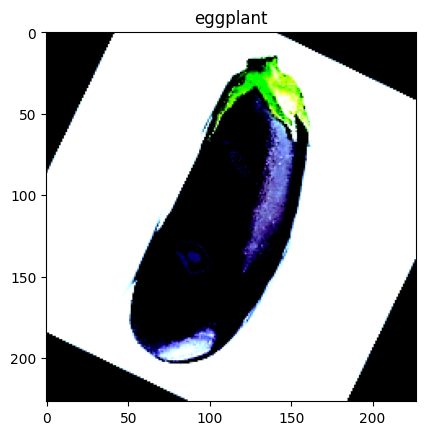

In [8]:
image, label = trainset[0] # (c,h,w) -> (h,w,c)

class_list = ['cucumber', 'eggplant', 'mushroom']

plt.imshow(image.permute(1, 2, 0))
plt.title(class_list[label])
# plt.axis('off')
# plt.show()

In [9]:
print(f"No. of examples in the training set: {len(trainset)}")
print(f"No. of examples in the validation set: {len(validset)}")

No. of examples in the training set: 148
No. of examples in the validation set: 38


# Load Dataset into Batches

In [10]:
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
validloader = DataLoader(validset, batch_size=BATCH_SIZE, shuffle=False)

In [11]:
print(f"No. of batches in trainloader : {len(trainloader)}")
print(f"No. of batches in validloader : {len(validloader)}")

No. of batches in trainloader : 10
No. of batches in validloader : 3


In [12]:
for images, labels in trainloader:
    break

print("One batch image shape:", images.shape) # (B, C, H, W)
print("One batch label shape:", labels.shape) # (B,)

One batch image shape: torch.Size([16, 3, 227, 227])
One batch label shape: torch.Size([16])


# Create Model

In [13]:
# Replace your "Create Model" cell with this corrected version

class ImageModel(nn.Module):
    def __init__(self):
        super(ImageModel, self).__init__()
        # --- (Layer definitions are the same) ---
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(in_channels = 3, out_channels = 16, kernel_size=(5, 5), padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(4, 4), stride=2),
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(5, 5), padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(4, 4), stride=2),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(5, 5), padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(4, 4), stride=2),
            nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size=(5, 5), padding=1),
            nn.ReLU(),
        )
        self.maxpool = nn.MaxPool2d(kernel_size=(4, 4), stride=2)
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(6400, 2048),
            nn.ReLU(),
            nn.Linear(2048, 3)
        )
        # --- (Properties to store results) ---
        self.gradient = None
        self.activations = None # Add a placeholder for activations

    def activation_hook(self, grad):
        self.gradient = grad

    # --- UPDATED FORWARD METHOD ---
    def forward(self, images, gradcam_hook=False):
        x = self.feature_extractor(images)
        
        # If the flag is set, store activations and register the hook
        if gradcam_hook:
            self.activations = x
            x.register_hook(self.activation_hook)
            
        x = self.maxpool(x)
        x = self.classifier(x)
        return x

    def get_activation_gradients(self):
        return self.gradient
    
    # This method is no longer needed since we store activations in forward()
    # def get_activation(self, x):
    #     return self.feature_extractor(x)

In [14]:
model = ImageModel()
model.to(DEVICE)  # Replace 'Device' with 'cuda' or 'cpu' as needed

ImageModel(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(4, 4), stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=(4, 4), stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=(4, 4), stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
  )
  (maxpool): MaxPool2d(kernel_size=(4, 4), stride=2, padding=0, dilation=1, ceil_mode=False)
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=6400, out_features=2048, bias=True)
    (2): ReLU()
    (3): Linear(in_features=2048, out_features=3, bias=True)
  )
)

# Create Train and Eval function

In [15]:
def train_fn(dataloader, model, optimizer, criterion, DEVICE):
    
    model.train()
    running_loss = 0.0  # You initialized 'running_loss' here
    for images, labels in tqdm(dataloader, desc="Training"):
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)

        optimizer.zero_grad()
        logits = model(images)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        # FIX 1: Use 'running_loss' to accumulate the loss
        running_loss += loss.item()

    # FIX 2: Return the correct variable
    return running_loss / len(dataloader)

In [16]:
# In your "Create Train and Eval function" cell, replace eval_fn

def eval_fn(dataloader, model, criterion, DEVICE):
    model.eval()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    
    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc="Validating"):
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)
            
            logits = model(images)
            loss = criterion(logits, labels)
            
            # --- NEW: Calculate Accuracy ---
            _, preds = torch.max(logits, 1)
            correct_predictions += (preds == labels).sum().item()
            total_samples += labels.size(0)
            
            running_loss += loss.item()
            
    accuracy = (correct_predictions / total_samples) * 100
    avg_loss = running_loss / len(dataloader)
    
    return avg_loss, accuracy

In [17]:
# %%
# %% [markdown]
# # Part 2: Transfer Learning with a Pre-trained ResNet18
# %%
from torchvision.models import resnet18, ResNet18_Weights

# 1. Load a ResNet18 model pre-trained on ImageNet
resnet_model = resnet18(weights=ResNet18_Weights.DEFAULT)

# 2. Freeze all the layers in the network
# We don't want to change the pre-trained feature weights initially
for param in resnet_model.parameters():
    param.requires_grad = False

# 3. Replace the final classifier layer
# The original ResNet was trained on 1000 classes. We only need 3.
num_ftrs = resnet_model.fc.in_features
resnet_model.fc = nn.Linear(num_ftrs, len(class_list)) # Replace with a new, unfrozen layer

# Move the new model to the device
resnet_model = resnet_model.to(DEVICE)



# Training Loop

In [18]:
# 4. Set up a new optimizer and loss function for the ResNet model
# We only need to train the final layer we just added

optimizer_resnet = torch.optim.Adam(resnet_model.parameters(), lr=LR)
criterion_resnet = nn.CrossEntropyLoss()


optimizer = torch.optim.Adam(model.parameters(), lr=LR)
criterion = nn.CrossEntropyLoss()

In [19]:
# In your "Training Loop" cell

best_valid_loss = np.inf

for i in range(EPOCHs):
    print(f"\n--- Epoch {i+1}/{EPOCHs} ---")
    
    train_loss = train_fn(trainloader, model, optimizer, criterion, DEVICE)
    
    # --- NEW: Unpack loss and accuracy ---
    valid_loss, valid_accuracy = eval_fn(validloader, model, criterion, DEVICE)
    
    print(f"Train Loss: {train_loss:.4f} | Valid Loss: {valid_loss:.4f} | Valid Accuracy: {valid_accuracy:.2f}%")

    if valid_loss < best_valid_loss:
        torch.save(model.state_dict(), 'custom_cnn_best.pth') # Rename for clarity
        best_valid_loss = valid_loss
        print("Model saved!")


--- Epoch 1/20 ---


Validating: 100%|██████████| 3/3 [00:00<00:00, 19.91it/s]


Train Loss: 1.1629 | Valid Loss: 0.8431 | Valid Accuracy: 57.89%
Model saved!

--- Epoch 2/20 ---


Validating: 100%|██████████| 3/3 [00:00<00:00, 62.50it/s]


Train Loss: 0.6889 | Valid Loss: 0.6347 | Valid Accuracy: 68.42%
Model saved!

--- Epoch 3/20 ---


Validating: 100%|██████████| 3/3 [00:00<00:00, 61.17it/s]


Train Loss: 0.7238 | Valid Loss: 0.4827 | Valid Accuracy: 89.47%
Model saved!

--- Epoch 4/20 ---


Validating: 100%|██████████| 3/3 [00:00<00:00, 62.69it/s]


Train Loss: 0.6310 | Valid Loss: 0.5284 | Valid Accuracy: 86.84%

--- Epoch 5/20 ---


Validating: 100%|██████████| 3/3 [00:00<00:00, 62.04it/s]


Train Loss: 0.5685 | Valid Loss: 0.5749 | Valid Accuracy: 86.84%

--- Epoch 6/20 ---


Validating: 100%|██████████| 3/3 [00:00<00:00, 62.45it/s]


Train Loss: 0.3567 | Valid Loss: 0.3479 | Valid Accuracy: 89.47%
Model saved!

--- Epoch 7/20 ---


Validating: 100%|██████████| 3/3 [00:00<00:00, 61.45it/s]


Train Loss: 0.2095 | Valid Loss: 0.2042 | Valid Accuracy: 89.47%
Model saved!

--- Epoch 8/20 ---


Validating: 100%|██████████| 3/3 [00:00<00:00, 56.73it/s]


Train Loss: 0.2208 | Valid Loss: 0.3215 | Valid Accuracy: 89.47%

--- Epoch 9/20 ---


Validating: 100%|██████████| 3/3 [00:00<00:00, 62.33it/s]


Train Loss: 0.4294 | Valid Loss: 0.2930 | Valid Accuracy: 86.84%

--- Epoch 10/20 ---


Validating: 100%|██████████| 3/3 [00:00<00:00, 60.40it/s]


Train Loss: 0.3998 | Valid Loss: 0.1386 | Valid Accuracy: 97.37%
Model saved!

--- Epoch 11/20 ---


Validating: 100%|██████████| 3/3 [00:00<00:00, 60.42it/s]


Train Loss: 0.3694 | Valid Loss: 0.1918 | Valid Accuracy: 89.47%

--- Epoch 12/20 ---


Validating: 100%|██████████| 3/3 [00:00<00:00, 56.34it/s]


Train Loss: 0.2355 | Valid Loss: 0.1892 | Valid Accuracy: 89.47%

--- Epoch 13/20 ---


Validating: 100%|██████████| 3/3 [00:00<00:00, 59.34it/s]


Train Loss: 0.1986 | Valid Loss: 0.1923 | Valid Accuracy: 94.74%

--- Epoch 14/20 ---


Validating: 100%|██████████| 3/3 [00:00<00:00, 60.98it/s]


Train Loss: 0.2005 | Valid Loss: 0.2557 | Valid Accuracy: 92.11%

--- Epoch 15/20 ---


Validating: 100%|██████████| 3/3 [00:00<00:00, 60.12it/s]


Train Loss: 0.1876 | Valid Loss: 0.1231 | Valid Accuracy: 94.74%
Model saved!

--- Epoch 16/20 ---


Validating: 100%|██████████| 3/3 [00:00<00:00, 51.99it/s]


Train Loss: 0.1307 | Valid Loss: 0.2003 | Valid Accuracy: 92.11%

--- Epoch 17/20 ---


Validating: 100%|██████████| 3/3 [00:00<00:00, 62.88it/s]


Train Loss: 0.1726 | Valid Loss: 0.1169 | Valid Accuracy: 97.37%
Model saved!

--- Epoch 18/20 ---


Validating: 100%|██████████| 3/3 [00:00<00:00, 58.81it/s]


Train Loss: 0.1869 | Valid Loss: 0.1460 | Valid Accuracy: 94.74%

--- Epoch 19/20 ---


Validating: 100%|██████████| 3/3 [00:00<00:00, 63.22it/s]


Train Loss: 0.1025 | Valid Loss: 0.0967 | Valid Accuracy: 94.74%
Model saved!

--- Epoch 20/20 ---


Validating: 100%|██████████| 3/3 [00:00<00:00, 56.96it/s]


Train Loss: 0.0473 | Valid Loss: 0.0517 | Valid Accuracy: 97.37%
Model saved!


In [20]:
# %% [markdown]
# # Train the ResNet18 Model

# %%
best_resnet_loss = np.inf

for i in range(EPOCHs):
    print(f"\n--- ResNet Epoch {i+1}/{EPOCHs} ---")
    
    # Use the same train_fn and eval_fn, just with the new model and optimizer
    train_loss_r = train_fn(trainloader, resnet_model, optimizer_resnet, criterion_resnet, DEVICE)
    valid_loss_r, valid_acc_r = eval_fn(validloader, resnet_model, criterion_resnet, DEVICE)
    
    print(f"ResNet Train Loss: {train_loss_r:.4f} | ResNet Valid Loss: {valid_loss_r:.4f} | ResNet Valid Accuracy: {valid_acc_r:.2f}%")

    if valid_loss_r < best_resnet_loss:
        # This line is what creates the missing file
        torch.save(resnet_model.state_dict(), 'resnet18_best.pth')
        best_resnet_loss = valid_loss_r
        print("ResNet model saved!")


--- ResNet Epoch 1/20 ---


Validating: 100%|██████████| 3/3 [00:00<00:00, 12.63it/s]


ResNet Train Loss: 0.9668 | ResNet Valid Loss: 0.7206 | ResNet Valid Accuracy: 81.58%
ResNet model saved!

--- ResNet Epoch 2/20 ---


Validating: 100%|██████████| 3/3 [00:00<00:00, 34.34it/s]


ResNet Train Loss: 0.7327 | ResNet Valid Loss: 0.4888 | ResNet Valid Accuracy: 94.74%
ResNet model saved!

--- ResNet Epoch 3/20 ---


Validating: 100%|██████████| 3/3 [00:00<00:00, 36.57it/s]


ResNet Train Loss: 0.6143 | ResNet Valid Loss: 0.3567 | ResNet Valid Accuracy: 97.37%
ResNet model saved!

--- ResNet Epoch 4/20 ---


Validating: 100%|██████████| 3/3 [00:00<00:00, 38.00it/s]


ResNet Train Loss: 0.4794 | ResNet Valid Loss: 0.2859 | ResNet Valid Accuracy: 97.37%
ResNet model saved!

--- ResNet Epoch 5/20 ---


Validating: 100%|██████████| 3/3 [00:00<00:00, 33.44it/s]


ResNet Train Loss: 0.4156 | ResNet Valid Loss: 0.2153 | ResNet Valid Accuracy: 97.37%
ResNet model saved!

--- ResNet Epoch 6/20 ---


Validating: 100%|██████████| 3/3 [00:00<00:00, 36.78it/s]


ResNet Train Loss: 0.3329 | ResNet Valid Loss: 0.2052 | ResNet Valid Accuracy: 97.37%
ResNet model saved!

--- ResNet Epoch 7/20 ---


Validating: 100%|██████████| 3/3 [00:00<00:00, 37.46it/s]


ResNet Train Loss: 0.4153 | ResNet Valid Loss: 0.1714 | ResNet Valid Accuracy: 97.37%
ResNet model saved!

--- ResNet Epoch 8/20 ---


Validating: 100%|██████████| 3/3 [00:00<00:00, 34.29it/s]


ResNet Train Loss: 0.3834 | ResNet Valid Loss: 0.1448 | ResNet Valid Accuracy: 97.37%
ResNet model saved!

--- ResNet Epoch 9/20 ---


Validating: 100%|██████████| 3/3 [00:00<00:00, 37.34it/s]


ResNet Train Loss: 0.2887 | ResNet Valid Loss: 0.1621 | ResNet Valid Accuracy: 97.37%

--- ResNet Epoch 10/20 ---


Validating: 100%|██████████| 3/3 [00:00<00:00, 36.39it/s]


ResNet Train Loss: 0.3253 | ResNet Valid Loss: 0.1266 | ResNet Valid Accuracy: 97.37%
ResNet model saved!

--- ResNet Epoch 11/20 ---


Validating: 100%|██████████| 3/3 [00:00<00:00, 30.73it/s]


ResNet Train Loss: 0.2504 | ResNet Valid Loss: 0.1034 | ResNet Valid Accuracy: 97.37%
ResNet model saved!

--- ResNet Epoch 12/20 ---


Validating: 100%|██████████| 3/3 [00:00<00:00, 36.72it/s]


ResNet Train Loss: 0.2754 | ResNet Valid Loss: 0.1421 | ResNet Valid Accuracy: 97.37%

--- ResNet Epoch 13/20 ---


Validating: 100%|██████████| 3/3 [00:00<00:00, 37.35it/s]


ResNet Train Loss: 0.2357 | ResNet Valid Loss: 0.0880 | ResNet Valid Accuracy: 97.37%
ResNet model saved!

--- ResNet Epoch 14/20 ---


Validating: 100%|██████████| 3/3 [00:00<00:00, 36.87it/s]


ResNet Train Loss: 0.1972 | ResNet Valid Loss: 0.1126 | ResNet Valid Accuracy: 97.37%

--- ResNet Epoch 15/20 ---


Validating: 100%|██████████| 3/3 [00:00<00:00, 37.82it/s]


ResNet Train Loss: 0.1860 | ResNet Valid Loss: 0.0930 | ResNet Valid Accuracy: 97.37%

--- ResNet Epoch 16/20 ---


Validating: 100%|██████████| 3/3 [00:00<00:00, 34.67it/s]


ResNet Train Loss: 0.1892 | ResNet Valid Loss: 0.0765 | ResNet Valid Accuracy: 97.37%
ResNet model saved!

--- ResNet Epoch 17/20 ---


Validating: 100%|██████████| 3/3 [00:00<00:00, 34.88it/s]


ResNet Train Loss: 0.3011 | ResNet Valid Loss: 0.0822 | ResNet Valid Accuracy: 97.37%

--- ResNet Epoch 18/20 ---


Validating: 100%|██████████| 3/3 [00:00<00:00, 37.92it/s]


ResNet Train Loss: 0.1905 | ResNet Valid Loss: 0.1093 | ResNet Valid Accuracy: 97.37%

--- ResNet Epoch 19/20 ---


Validating: 100%|██████████| 3/3 [00:00<00:00, 36.54it/s]


ResNet Train Loss: 0.2138 | ResNet Valid Loss: 0.0624 | ResNet Valid Accuracy: 97.37%
ResNet model saved!

--- ResNet Epoch 20/20 ---


Validating: 100%|██████████| 3/3 [00:00<00:00, 38.01it/s]

ResNet Train Loss: 0.1980 | ResNet Valid Loss: 0.0778 | ResNet Valid Accuracy: 97.37%


# Get GradCAM Final Analysis: Comparing Model Interpretability

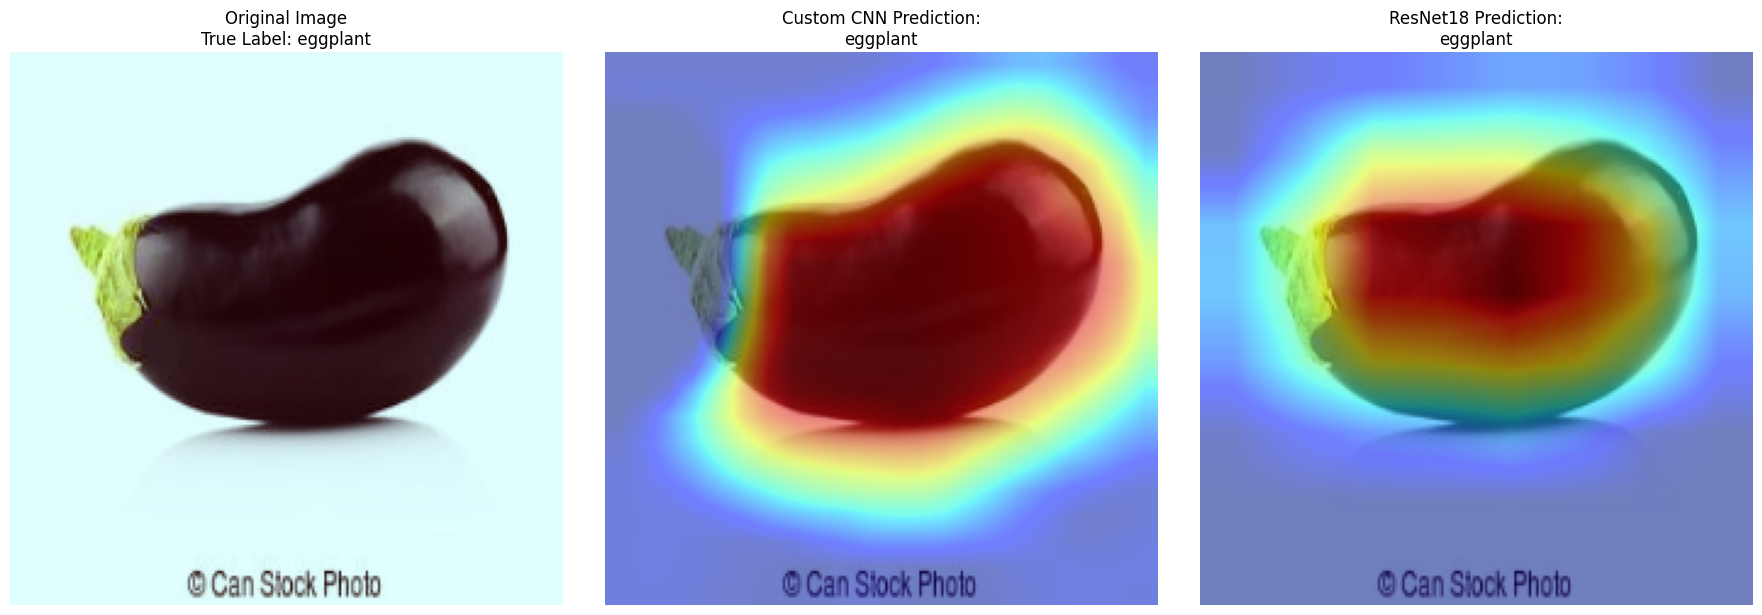

In [21]:
# %% [markdown]
# # Final Analysis: Comparing Model Interpretability

# %%
from torchvision.models import resnet18
from sklearn.metrics import confusion_matrix
import seaborn as sns

def generate_comparison_plot(img_idx):
    
    # --- HELPER FUNCTION (Defined inside to have correct scope) ---
    def generate_heatmap(model, target_layer, img_tensor):
        # These variables belong to generate_heatmap
        gradients = None
        activations = None

        # This hook is nested inside and can modify the parent's variables
        def backward_hook(grad):
            nonlocal gradients
            gradients = grad

        def forward_hook(module, input, output):
            nonlocal activations
            activations = output

        # Register hooks
        forward_handle = target_layer.register_forward_hook(forward_hook)
        pred = model(img_tensor) # Forward pass
        
        backward_handle = activations.register_hook(backward_hook)
        pred[:, pred.argmax()].backward() # Backward pass
        
        # Clean up
        forward_handle.remove()
        backward_handle.remove()
        
        # Process heatmap
        pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])
        for i in range(activations.shape[1]):
            activations[:, i, :, :] *= pooled_gradients[i]
        
        heatmap = torch.mean(activations, dim=1).squeeze().cpu().detach()
        heatmap = nn.ReLU()(heatmap)
        heatmap /= torch.max(heatmap)
        
        return heatmap, class_list[pred.argmax().item()]

    # --- MAIN LOGIC ---
    # Data Setup
    inference_set = utils.ImageDataset(valid_df, augs=valid_augs, data_dir=DATA_DIR)
    image, label = inference_set[img_idx]
    img_tensor = image.unsqueeze(0).to(DEVICE)
    
    # Denormalize
    std = np.array([0.229, 0.224, 0.225]); mean = np.array([0.485, 0.456, 0.406])
    denorm_image = image.permute(1, 2, 0).numpy() * std + mean
    denorm_image = np.clip(denorm_image, 0, 1)

    # Load Models
    custom_model = ImageModel().to(DEVICE)
    custom_model.load_state_dict(torch.load('custom_cnn_best.pth'))
    custom_model.eval()

    resnet_model_loaded = resnet18()
    resnet_model_loaded.fc = nn.Linear(resnet_model_loaded.fc.in_features, len(class_list))
    resnet_model_loaded.to(DEVICE)
    resnet_model_loaded.load_state_dict(torch.load('resnet18_best.pth'))
    resnet_model_loaded.eval()

    # Generate Heatmaps
    heatmap_custom, pred_custom = generate_heatmap(custom_model, custom_model.feature_extractor[-2], img_tensor)
    heatmap_resnet, pred_resnet = generate_heatmap(resnet_model_loaded, resnet_model_loaded.layer4, img_tensor)

    # Plotting
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    axes[0].imshow(denorm_image)
    axes[0].set_title(f"Original Image\nTrue Label: {class_list[label]}")
    axes[0].axis('off')

    axes[1].imshow(denorm_image)
    axes[1].imshow(cv2.resize(heatmap_custom.numpy(), (denorm_image.shape[1], denorm_image.shape[0])), cmap='jet', alpha=0.5)
    axes[1].set_title(f"Custom CNN Prediction:\n{pred_custom}")
    axes[1].axis('off')
    
    axes[2].imshow(denorm_image)
    axes[2].imshow(cv2.resize(heatmap_resnet.numpy(), (denorm_image.shape[1], denorm_image.shape[0])), cmap='jet', alpha=0.5)
    axes[2].set_title(f"ResNet18 Prediction:\n{pred_resnet}")
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()

# --- Run the Analysis ---
generate_comparison_plot(img_idx=15)

## Final Analysis: Comparing Custom CNN vs. ResNet18 via Grad-CAM

### Overall Conclusion
Based on the visual evidence from the Grad-CAM heatmaps, the ResNet18 model is demonstrably superior and more robust than the custom-built CNN. While both models achieved the correct prediction ("eggplant"), the heatmaps reveal a significant difference in the sophistication of their underlying decision-making processes.

### Detailed Heatmap Analysis
The Grad-CAM visualizations provide deep insight into what each model considers important when making a prediction.

1. Precision and Focus
Custom CNN: The heatmap is diffuse and generalized. The area of high activation (red) covers the eggplant's body but also bleeds significantly into the background and the object's shadow. This suggests the model has learned a simple rule based on a "large, dark, oblong shape."
ResNet18: The heatmap is tight, focused, and precise. The activation is strongly concentrated on the eggplant itself, and the heatmap's boundaries align closely with the vegetable's silhouette. This indicates a superior ability to distinguish the subject from the background.

2. Feature Complexity and Specificity
Custom CNN: The model's attention is primarily on the broad, featureless part of the eggplant's body. This represents a low-level feature—essentially just color and basic shape.
ResNet18: The model focuses intensely on two specific, high-information areas that are key identifiers:
The skin's reflective highlight: It recognizes that the glossy texture and light reflection are important features.
The calyx (the green stem/cap): It identifies the junction between the green cap and the purple body as a highly discriminative feature.
This proves that ResNet18 has learned a more complex and reliable rule based on texture and the combination of specific object parts.

3. Robustness to Distractions
Custom CNN: The model is clearly distracted by irrelevant information. Its heatmap shows activation on the shadow below the eggplant and even gives some low-level attention to the "© Can Stock Photo" watermark. This is a major red flag, suggesting it might fail if the background changes.
ResNet18: The model almost completely ignores the background, shadow, and watermark. Its focus is exclusively on the features of the vegetable itself. This demonstrates that it has learned to be invariant to the background, making it a far more generalizable and reliable model.
The Power of Transfer Learning: Why ResNet18 is Better
This comparison perfectly illustrates the value of transfer learning.

Our Custom CNN had to learn all visual features from scratch using only the provided dataset. It successfully learned basic shapes and colors, which is commendable.

ResNet18 began with a massive advantage. Having been pre-trained on the vast ImageNet dataset, it already possessed a rich "visual vocabulary" for identifying complex edges, textures, patterns, and object parts.
When we fine-tuned ResNet18, we were not teaching it how to see; we were teaching an expert vision system to apply its existing, sophisticated knowledge to our specific problem. This is why it could immediately identify the subtle, high-level features that truly define an eggplant, leading to a more precise, robust, and "intelligent" conclusion.

